In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts,StepLR, OneCycleLR

from utils.Models import MLP
from utils.Datasets import BBdataset

torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
def gen_bridge(x, y, ts, T, num_samples):
    sigma=1
    bridge = torch.zeros((ts.shape[0], num_samples))
    drift = torch.zeros((ts.shape[0], num_samples))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]      # dt = epsilon
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

In [3]:
num_samples = 2000
mu1 = -4
mu2 = 4
sigma = 1
epsilon = 0.001
T = 1


# 定义参数
def gen_data(mu1=-2, mu2=2, sigma=1, num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    # 生成初始密度的样本 (标准高斯分布)
    initial_density_samples = np.random.normal(0, 1, 2 * num_samples)

    # 生成终止密度的样本 (两个高斯分布)
    target_density_samples1 = np.random.normal(mu1, sigma, num_samples)
    target_density_samples2 = np.random.normal(mu2, sigma, num_samples)
    target_density_samples = np.concatenate([target_density_samples1, target_density_samples2])

    # 返回生成的样本
    ts = torch.arange(0, T+epsilon, epsilon)
    initial_density_samples = torch.Tensor(initial_density_samples)
    target_density_samples = torch.Tensor(target_density_samples)
    bridge, drift = gen_bridge(initial_density_samples, target_density_samples, ts, T=T, num_samples=2*num_samples)
    return ts, bridge, drift, initial_density_samples, target_density_samples

ts, bridge, drift, source_sample, target_sample = gen_data(mu1=mu1, mu2=mu2, sigma=sigma, num_samples=num_samples/2, epsilon=epsilon, T=T)

In [4]:
def gen_src_dst(mu=0, sigma=1):
    dis = torch.distributions.normal.Normal(torch.Tensor([mu]), torch.Tensor([sigma]))
    src_dst = lambda x: dis.sample((x,))
    return src_dst

def gen_tgt_dst(mu1=-2,mu2=2,sigma=1):
    dis1 = torch.distributions.normal.Normal(torch.Tensor([mu1]), torch.Tensor([sigma]))
    dis2 = torch.distributions.normal.Normal(torch.Tensor([mu2]), torch.Tensor([sigma]))
    tgt_dst = lambda x: torch.cat([dis1.sample((x//2,)), dis2.sample((x//2,))])
    return tgt_dst
src_dst = gen_src_dst()
tgt_dst = gen_tgt_dst(mu1=mu1, mu2=mu2, sigma=sigma)
tgt_dst(1000).shape

torch.Size([1000, 1])

/tmp/ipykernel_14322/3368500952.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Gaussian to 2$\\times$Gaussian'}>)

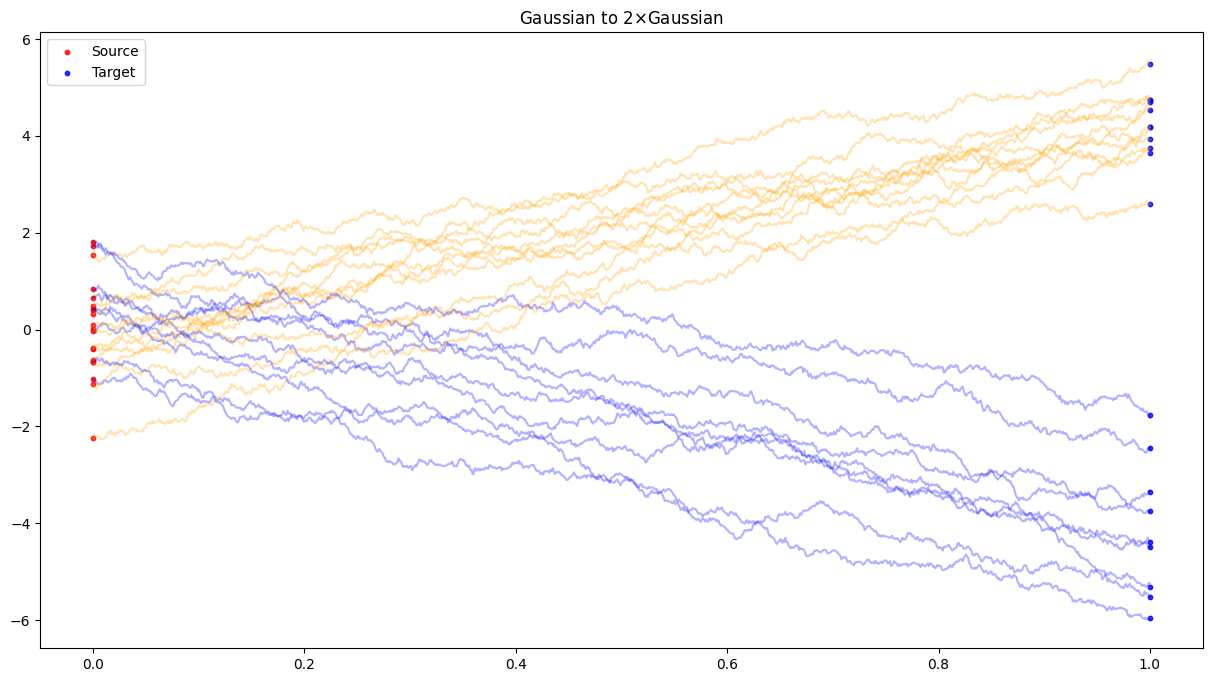

In [5]:
def plot_bridge(ts, bridge, source_sample, target_sample, show_rate=1.0, title=r'Gaussian to 2$\times$Gaussian'):
    if show_rate < 1.0:
        indices = np.arange(len(source_sample))

        # 打乱索引数组
        np.random.shuffle(indices)

        # 重新排列数组
        source_sample = source_sample[indices]
        target_sample = target_sample[indices]
        bridge = bridge[:, indices]
        
        source_sample = source_sample[:int(len(source_sample) * show_rate)]
        target_sample = target_sample[:int(len(target_sample) * show_rate)]
        bridge = bridge[:, :int(bridge.shape[-1] * show_rate)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.scatter(np.zeros_like(source_sample), source_sample, c='r', alpha=0.8, label='Source', s=10)
    ax.scatter(np.ones_like(target_sample), target_sample, c='b', alpha=0.8, label='Target', s=10)
    # ax.plot(ts, bridge, c='gray', alpha=0.3)
    
    for i in range(bridge.shape[1]):
        line_color = 'orange' if bridge[-1, i] > 0 else 'blue'
        plt.plot(ts, bridge[:, i], color=line_color, alpha=0.3)
    
    ax.set_title(title)
    ax.legend()
    fig.show()
    return fig, ax

plot_bridge(ts, bridge, source_sample, target_sample, show_rate=0.01)

In [51]:
start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1), 1, dim=1), dim=0)
times = ts[:len(ts)-1].repeat(num_samples).reshape(-1, 1)
positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)

status = torch.cat(torch.split(torch.where(target_sample > 0, 1, 0).repeat(len(ts)-1, 1), 1, dim=1), dim=0)

scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)

raw_data = torch.concat([start, times, positions, status, scores], dim=1)

In [52]:
raw_data.shape

torch.Size([2000000, 5])

==========model==========
MLP(
  (fcin): Linear(in_features=4, out_features=256, bias=True)
  (fcs): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fcout): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)


Training (lr: 0.00010)  (loss=8.38932): 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


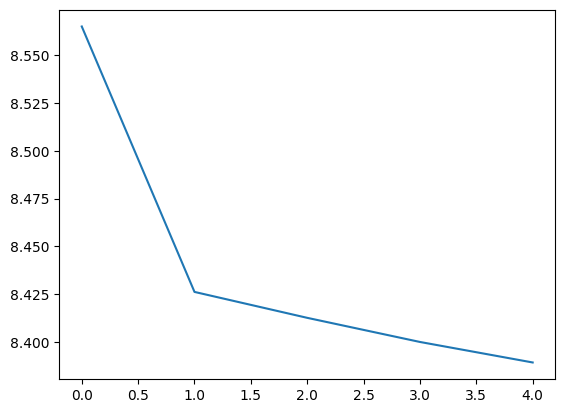

In [53]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    model.to(device)
    for training_data in train_dl:
        training_data = training_data.float()
        x, y = training_data[:, :-1], training_data[:, -1:]
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

epochs = 5
batch_size = 1000
lr = 1e-4

# 组合成data
train_ds = BBdataset(raw_data)
train_dl = DataLoader(train_ds, batch_size=batch_size,num_workers=8, shuffle=True)

model = MLP(input_dim=4, output_dim=1, hidden_layers=2, hidden_dim=256)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_list = []
print('='*10+'model'+'='*10)
# print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
print(model)

epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
model.train()
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, None, loss_fn)
    loss_list.append(now_loss)
    cur_lr = optimizer.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
epoch_iterator.close()
plt.plot(loss_list)

In [54]:
# from tqdm import tqdm
# def better_train(model, src_dst, tgt_dst, ts, epochs, batch_size , optimizer, scheduler, loss_fn):
#     model.train()
#     model.to(device)
#     ts = ts.to(device)
#     loss_lst = []
#     for i in tqdm(range(epochs)):
#         src_data = src_dst(batch_size).to(device)
#         permut = torch.randperm(batch_size)
#         tgt_data = tgt_dst(batch_size).index_select(0, permut).to(device)
#         status = torch.where(tgt_data > 0, 1, 0)
#         losses = 0
#         now_pos = src_data
#         for j in range(len(ts)-1):
#             t = ts[j]
#             dydt = (tgt_data - now_pos) / (1-t)
#             x = torch.concat([src_data, t.repeat(batch_size, 1), now_pos, status], dim=1)
#             logis = model(x)
#             loss = loss_fn(logis, dydt)
#             loss.backward()
#             losses += loss.item()
#             optimizer.step()
#             if scheduler is not None:
#                 scheduler.step()
#             optimizer.zero_grad()
            
#             dt = ts[j+1]-ts[j]
#             now_pos += dydt*dt + torch.sqrt(dt)*torch.randn((batch_size,1), device=device)
#         loss_lst.append(losses/len(ts))
#     return loss_lst

# model = MLP(input_dim=4, output_dim=1, hidden_layers=3, hidden_dim=512)
# lr = 1e-3
# epochs = 10
# batch_size = 2000
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn = nn.MSELoss()
# scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
# loss_lst = better_train(model, src_dst, tgt_dst, ts, epochs, batch_size, optimizer, None, loss_fn)
# plt.plot(loss_lst)

In [55]:
# epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
# model.train()
# for e in epoch_iterator:
#     now_loss = train(model ,train_dl, optimizer, None, loss_fn)
#     loss_list.append(now_loss)
#     cur_lr = optimizer.param_groups[-1]['lr']
#     epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
# epoch_iterator.close()

In [58]:
test_num_samples = 100
test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_data(mu1=mu1, mu2=mu2, sigma=sigma, num_samples=test_num_samples/2, epsilon=epsilon, T=T)
pred_bridge = torch.zeros((test_ts.shape[0], test_num_samples))
pred_bridge[0, :] = test_source_sample
model.eval()
model.cpu()

prior_status = 1

with torch.no_grad():
    status = torch.ones_like(test_source_sample).unsqueeze(-1)*prior_status
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample.reshape(-1, 1)
        test_ts_reshaped = test_ts[i].reshape(-1, 1).repeat(test_num_samples, 1)
        pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1)
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped,status], axis=-1)
        dydt = model(x)
        dydt = dydt[:, 0]
        diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples)
        pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion

/tmp/ipykernel_14322/3368500952.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


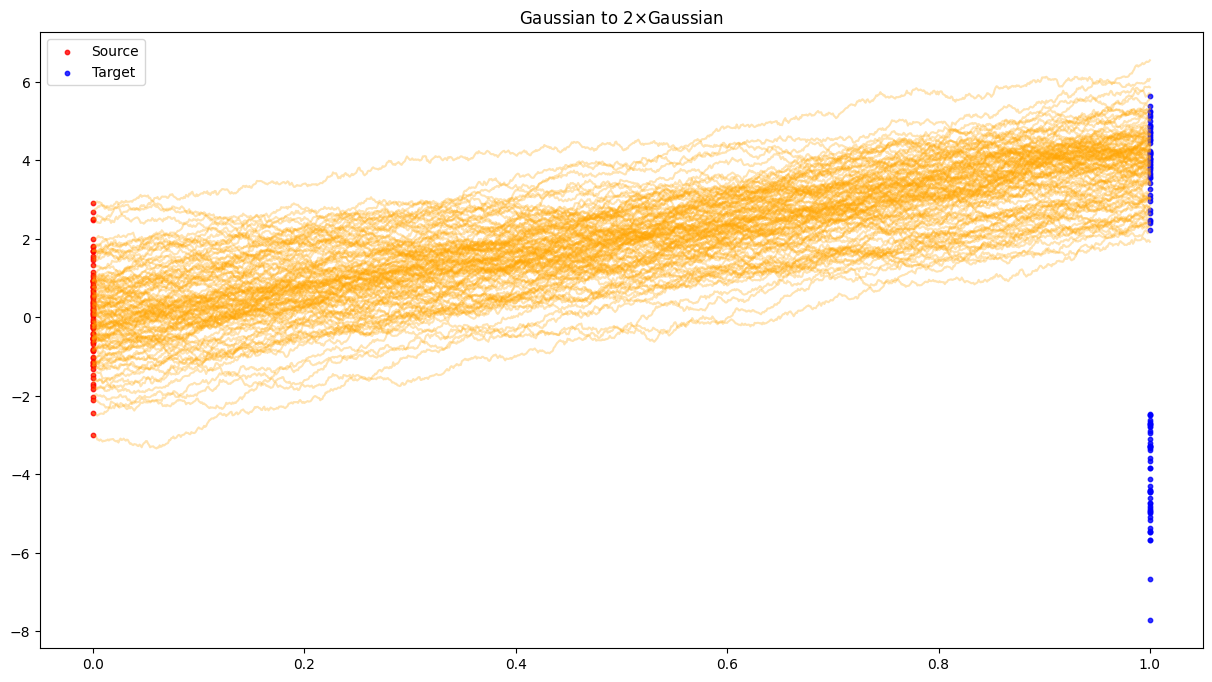

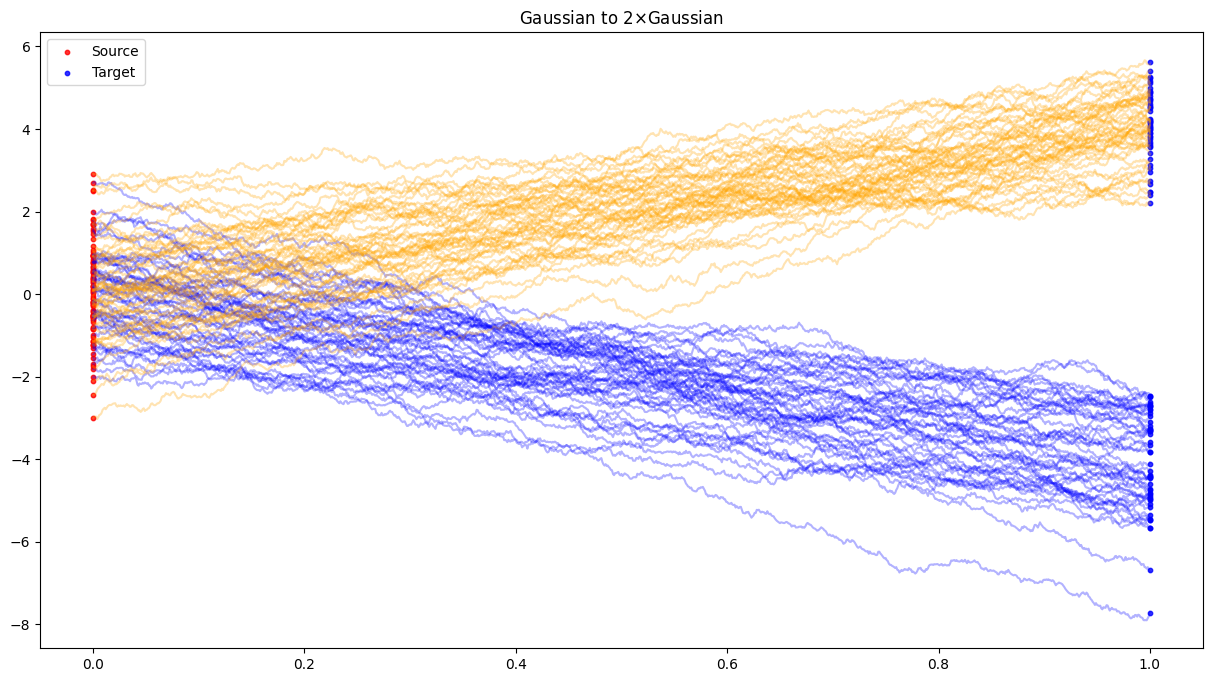

In [59]:
plot_bridge(test_ts, pred_bridge, test_source_sample, test_target_sample, show_rate=1)
plot_bridge(test_ts, test_bridge, test_source_sample, test_target_sample, show_rate=1)
plt.savefig('outs/gaussian2gaussian_bridge.jpg', dpi=300, bbox_inches='tight')